Welcome to pull your data and create your charts section. Please download the requirements.txt from the Repo to the same directory as this notebook and run **!pip install -r requirements.txt** below.

In [1]:
from azure.cosmos import CosmosClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Here, you are getting the data from your CosmosDB Service that you created, go to your CosmosDB Service and search "Keys".
# endpoint variable below is the 'URI' listed on there. key variable below is the 'PRIMARY KEY'. Copy and paste those inside the quotation marks.

endpoint = "" # --> URI from the CosmosDB/Keys
key = "" # --> PRIMARY KEY from the CosmosDB/Keys
database_name = "IoTData"
container_name = "Telemetry"

client = CosmosClient(endpoint, key)
database = client.get_database_client(database_name)
container = database.get_container_client(container_name)

all_items = list(container.read_all_items())

import json
with open("cosmos_data.json", "w") as f:
    json.dump(all_items, f, indent=2)


In [2]:


# all_items is the full list you got from container.read_all_items()
# Now extract just the "Body" from each document
body_data = [item["Body"] for item in all_items if "Body" in item]

# Convert to DataFrame
df = pd.DataFrame(body_data)

# Show first few rows
df.head()


,DeviceId,timestamp,temperature(C),humidity(%),pressure(hPa),magnetometer_x(mG),magnetometer_y(mG),magnetometer_z(mG),gyroscope_x(dps),gyroscope_y(dps),gyroscope_z(dps),accelerometer_x(mg),accelerometer_y(mg),accelerometer_z(mg)
0,DISCO-id1,8/7/2025 - 18:37:58,28.30,43.01,760.15,422,-386,-357,0,0,0,0,0,0
1,DISCO-id1,8/7/2025 - 18:38:5,27.60,42.22,1020.59,437,-364,-347,-210,-490,-560,-5,20,1022
2,DISCO-id1,8/7/2025 - 18:38:10,27.60,42.22,1020.52,434,-370,-350,-210,-420,-490,-6,20,1022
3,DISCO-id1,8/7/2025 - 18:56:46,22.77,53.10,760.15,320,-536,-382,0,0,0,0,0,0
4,DISCO-id1,8/7/2025 - 18:56:53,24.90,49.20,1013.20,425,-442,-353,-1050,-280,-700,-1,-29,1017


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DeviceId             709 non-null    object 
 1   timestamp            709 non-null    object 
 2   temperature(C)       709 non-null    float64
 3   humidity(%)          709 non-null    float64
 4   pressure(hPa)        709 non-null    float64
 5   magnetometer_x(mG)   709 non-null    int64  
 6   magnetometer_y(mG)   709 non-null    int64  
 7   magnetometer_z(mG)   709 non-null    int64  
 8   gyroscope_x(dps)     709 non-null    int64  
 9   gyroscope_y(dps)     709 non-null    int64  
 10  gyroscope_z(dps)     709 non-null    int64  
 11  accelerometer_x(mg)  709 non-null    int64  
 12  accelerometer_y(mg)  709 non-null    int64  
 13  accelerometer_z(mg)  709 non-null    int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 77.7+ KB


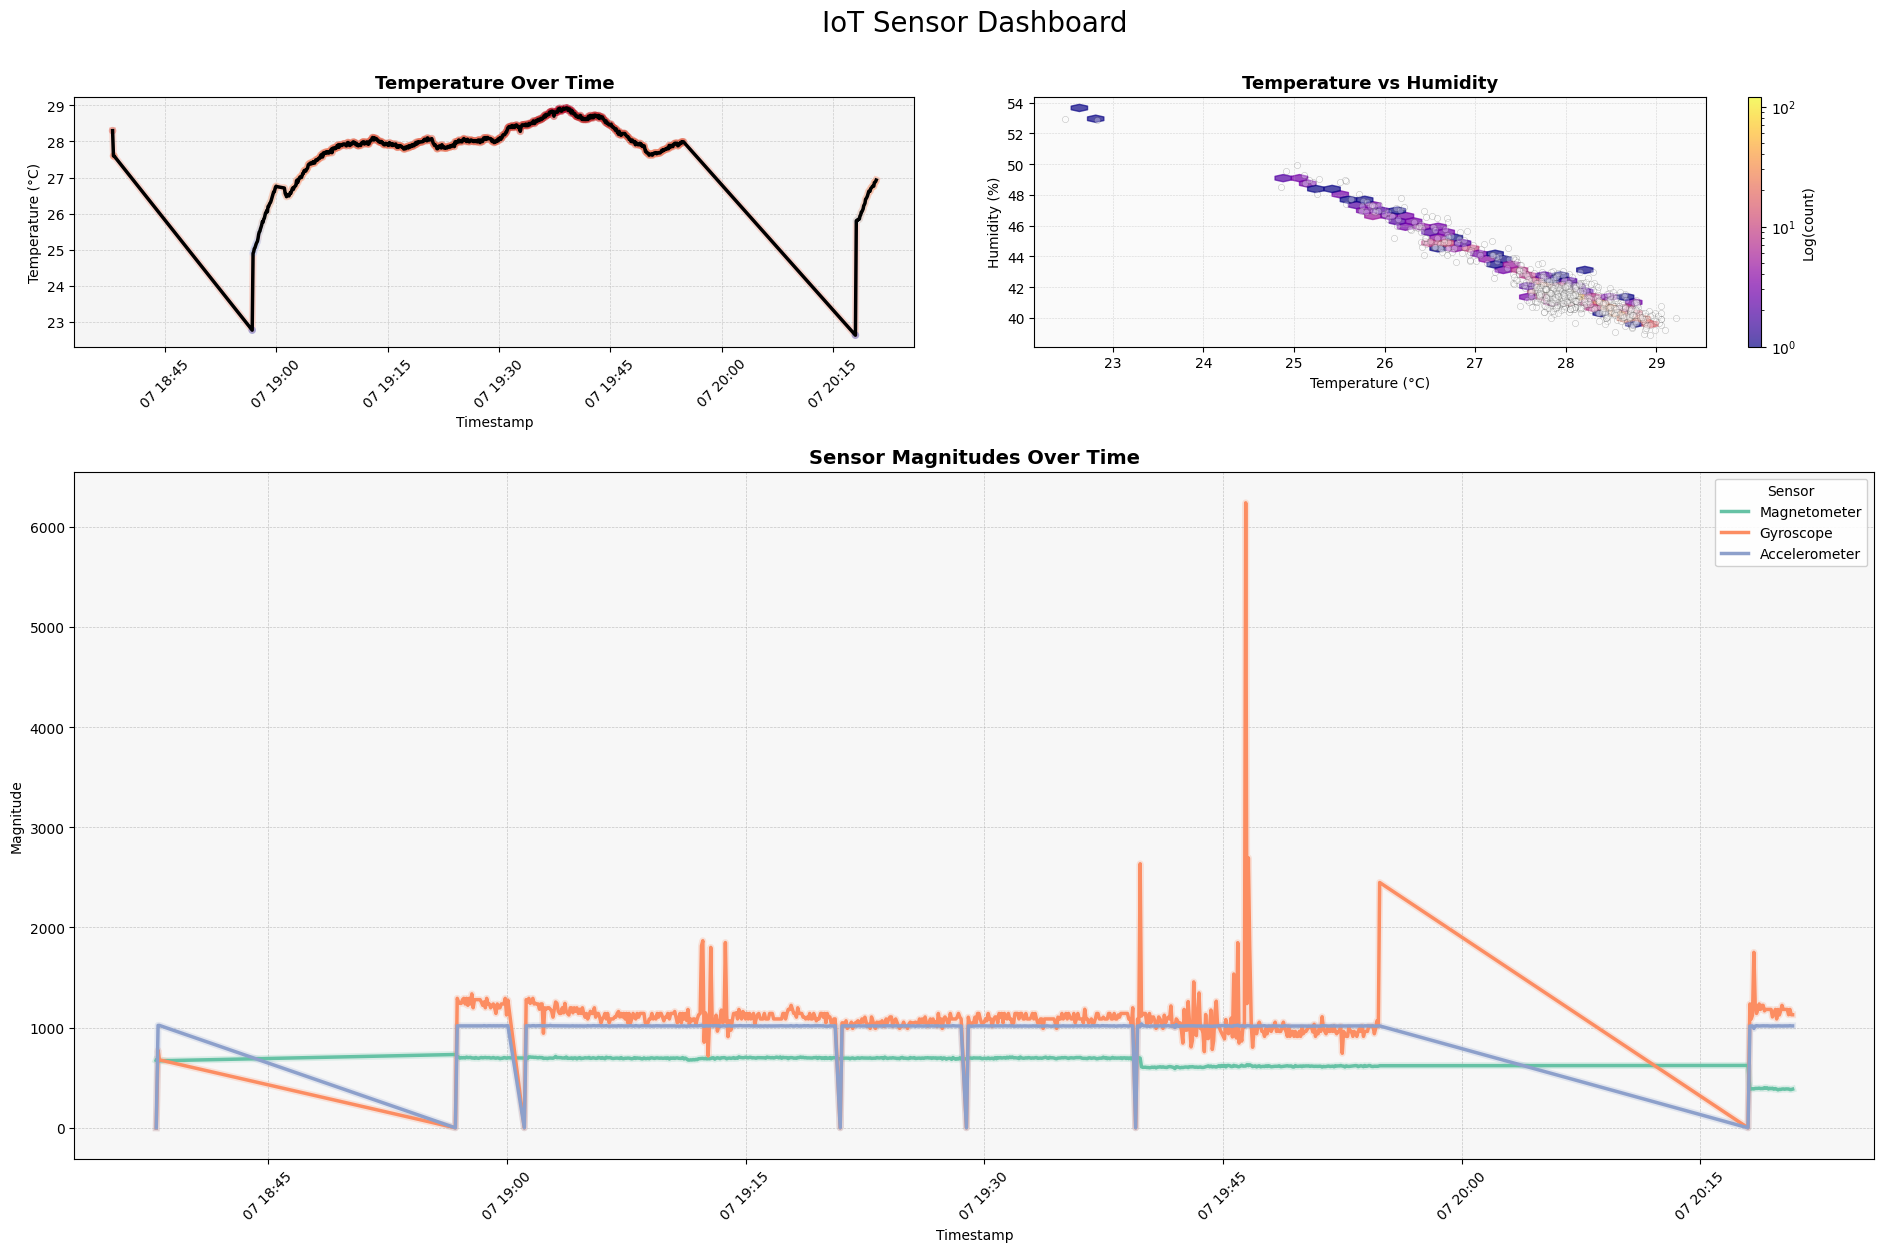

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure timestamp is parsed correctly
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Compute sensor magnitudes
df["magnetometer_mag"] = np.sqrt(df["magnetometer_x(mG)"]**2 +
                                 df["magnetometer_y(mG)"]**2 +
                                 df["magnetometer_z(mG)"]**2)

df["gyroscope_mag"] = np.sqrt(df["gyroscope_x(dps)"]**2 +
                              df["gyroscope_y(dps)"]**2 +
                              df["gyroscope_z(dps)"]**2)

df["accelerometer_mag"] = np.sqrt(df["accelerometer_x(mg)"]**2 +
                                  df["accelerometer_y(mg)"]**2 +
                                  df["accelerometer_z(mg)"]**2)

# Create figure
fig = plt.figure(figsize=(20, 12.5))

# === 1. Temperature Over Time ===
ax1 = fig.add_axes([0.05, 0.7, 0.42, 0.2])
base_color = "black"
highlight_color = "#FF5733"  # bright accent


sns.lineplot(data=df, x="timestamp", y="temperature(C)", ax=ax1,
             lw=5, color=highlight_color, alpha=0.2, zorder=1)
sns.lineplot(data=df, x="timestamp", y="temperature(C)", ax=ax1,
             lw=2.5, color=base_color, zorder=2)

scatter_colors = sns.color_palette("coolwarm", as_cmap=True)
ax1.scatter(df["timestamp"], df["temperature(C)"],
            c=df["temperature(C)"], cmap=scatter_colors, s=30, alpha=0.4, edgecolor="none")

ax1.set_title("Temperature Over Time", fontsize=13, weight='bold')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Temperature (°C)")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax1.set_facecolor("#f5f5f5")

# === 2. Hexbin + Swarm Overlay ===
ax2 = fig.add_axes([0.53, 0.7, 0.42, 0.2])
hb = ax2.hexbin(df["temperature(C)"], df["humidity(%)"],
                gridsize=35, cmap="plasma", bins="log", alpha=0.7)

temp_jitter = df["temperature(C)"] + np.random.normal(0, 0.1, size=len(df))
hum_jitter = df["humidity(%)"] + np.random.normal(0, 0.5, size=len(df))
ax2.scatter(temp_jitter, hum_jitter, color='white', edgecolor='black',
            alpha=0.3, s=20, linewidths=0.3)

ax2.set_title("Temperature vs Humidity", fontsize=13, weight='bold')
ax2.set_xlabel("Temperature (°C)")
ax2.set_ylabel("Humidity (%)")
fig.colorbar(hb, ax=ax2, label="Log(count)")
ax2.grid(True, linestyle='--', linewidth=0.4, alpha=0.5)
ax2.set_facecolor("#fafafa")

# === 3. Sensor Magnitudes Over Time ===
ax3 = fig.add_axes([0.05, 0.05, 0.9, 0.55])
palette = sns.color_palette("Set2", 3)

for sensor, color in zip(["magnetometer_mag", "gyroscope_mag", "accelerometer_mag"], palette):
    sns.lineplot(data=df, x="timestamp", y=sensor, ax=ax3,
                 lw=5, color=color, alpha=0.2, zorder=1)
    sns.lineplot(data=df, x="timestamp", y=sensor,
                 label=sensor.split("_")[0].capitalize(), ax=ax3,
                 lw=2.5, color=color, zorder=2)

ax3.set_title("Sensor Magnitudes Over Time", fontsize=14, weight='bold')
ax3.set_xlabel("Timestamp")
ax3.set_ylabel("Magnitude")
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax3.legend(title="Sensor", loc="upper right", frameon=True, framealpha=0.9)
ax3.set_facecolor("#f7f7f7")

# === Final Title ===
fig.suptitle("IoT Sensor Dashboard", fontsize=20, y=0.97)
plt.show()
